In [1]:
from cytoflow import *
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
import tqdm

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", { "xtick.major.size": 4, "ytick.major.size": 4, "font_color":'k', 'axes.edgecolor': 'k', 'xtick.color': 'k', 'ytick.color': 'k'})
sns.set_context("talk", font_scale=1.0)

In [2]:
plasmids = [[1260, 78, 1440, 80, 141, 142],
        [ 92, 144, 131, 134, 133, 135],
        [125, 129, 130, 126, 127, 132],
        [ 79, 136, 138,  90,  91, 157]
    ]

plasmids = [p for l in plasmids for p in l]
plasmids

[1260,
 78,
 1440,
 80,
 141,
 142,
 92,
 144,
 131,
 134,
 133,
 135,
 125,
 129,
 130,
 126,
 127,
 132,
 79,
 136,
 138,
 90,
 91,
 157]

In [3]:
plasmid_dict = { # maps plasmid number => plasmid name 
    1260 : "rTetR only",
    78 : "Ctrl - Ctrl",
    1440 : "MYBA only",
    80 : "BIN1 - FOXO3",
    141 : "BIN1 - Ctrl",
    142 : "Ctrl - FOXO3",
    92 : "SMCA2 - U2AF4",
    144 : "SMCA2 - Ctrl",
    131 : "U2AF4 - Ctrl",
    134 : "MYBA - ZN473",
    133 : "MYBA - Ctrl",
    135 : "Ctrl - ZN473",
    125 : "BTK - ABL1",
    129 : "BTK - Ctrl",
    130 : "Ctrl - ABL1",
    126 : "U2AF4 - BTK",
    127 : "BTK - WWP2",
    132 : "CTRL - WWP2",
    79 : "ANM2 - KIBRA",
    136 : "ANM2 - Ctrl",
    138 : "KIBRA - Ctrl",
    90 : "NOTC2 - ANM2",
    91 : "NOTC2 - KIBRA",
    157 : "NOTC2 - Ctrl"
}

In [4]:
%%time

df = pd.read_csv('./data/all_cells_live_mch_gated.csv')
df = df[(df['P1'])&(df['mCherry'])]
df

CPU times: user 1.39 s, sys: 201 ms, total: 1.59 s
Wall time: 1.62 s


,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry
0,357657344.0,130077184.0,0.0,rTetR only,214476800.0,935936.0,1260,1.0,True,True
1,613253888.0,186921472.0,0.0,rTetR only,88771328.0,1988608.0,1260,1.0,True,True
2,409882368.0,184542208.0,0.0,rTetR only,340477184.0,2286848.0,1260,1.0,True,True
3,438074880.0,229615616.0,0.0,rTetR only,140216320.0,2050560.0,1260,1.0,True,True
4,550200064.0,295275008.0,0.0,rTetR only,163602944.0,2893824.0,1260,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...
1685738,518283520.0,158495488.0,2.0,NOTC2 - Ctrl,98124544.0,1948672.0,157,2.0,True,True
1685739,722553088.0,150331904.0,2.0,NOTC2 - Ctrl,40823296.0,2093056.0,157,2.0,True,True
1685740,759366144.0,261527296.0,2.0,NOTC2 - Ctrl,191577600.0,2949632.0,157,2.0,True,True
1685741,552823296.0,149416960.0,2.0,NOTC2 - Ctrl,106409984.0,2251008.0,157,2.0,True,True


In [5]:
counts = df.groupby(['plasmid', 'description', 'replicate', 'day']).count().reset_index()
counts.sort_values(by = 'P1').head() # fewest sampled ones

,plasmid,description,replicate,day,FSC 488/10-A,SSC 488/10-A,mCherry-A,mCitrine-A,P1,mCherry
38,125,BTK - ABL1,1.0,2.0,297,297,297,297,297,297
36,125,BTK - ABL1,1.0,0.0,433,433,433,433,433,433
37,125,BTK - ABL1,1.0,1.0,447,447,447,447,447,447
83,133,MYBA - Ctrl,2.0,2.0,472,472,472,472,472,472
125,144,SMCA2 - Ctrl,2.0,2.0,1016,1016,1016,1016,1016,1016


# Computing and applying mCitrine threshold by day

In [6]:
def get_citrine_threshold(day):
    # return mean + 2 SDs of pJT126
    data = df[df['day']==day]
    data = data[data['plasmid']==1260]
    return np.mean(data['mCitrine-A']) + 4 * np.std(data['mCitrine-A'])

In [7]:
np.log10(get_citrine_threshold(0))

6.957928885154152

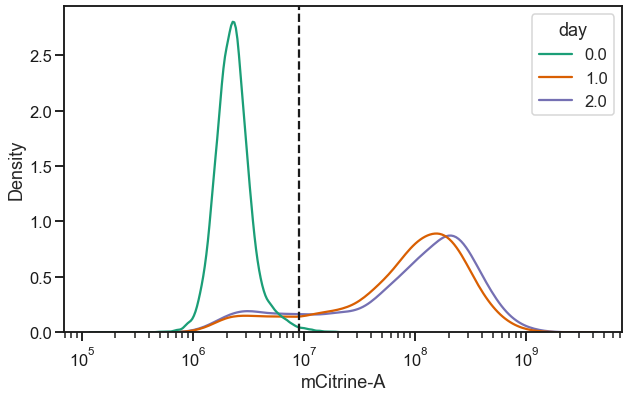

In [8]:
cdf = df[(df['plasmid']==1440)]
g = sns.kdeplot(
    data = cdf,
    x = 'mCitrine-A',
    hue = 'day',
    palette = 'Dark2',
    common_norm = False,
    log_scale = True
)
g.axvline(get_citrine_threshold(0), color = 'k', linestyle = '--')

In [9]:
%%time

day_thresh_dict = {d : get_citrine_threshold(d) for d in [0, 1, 2]}

days = list(df['day'])
cits = list(df['mCitrine-A'])
ons = [c >= day_thresh_dict[d] for c, d in zip(cits, days)]
df['Citrine On'] = ons
df

CPU times: user 560 ms, sys: 66.8 ms, total: 626 ms
Wall time: 610 ms


,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry,Citrine On
0,357657344.0,130077184.0,0.0,rTetR only,214476800.0,935936.0,1260,1.0,True,True,False
1,613253888.0,186921472.0,0.0,rTetR only,88771328.0,1988608.0,1260,1.0,True,True,False
2,409882368.0,184542208.0,0.0,rTetR only,340477184.0,2286848.0,1260,1.0,True,True,False
3,438074880.0,229615616.0,0.0,rTetR only,140216320.0,2050560.0,1260,1.0,True,True,False
4,550200064.0,295275008.0,0.0,rTetR only,163602944.0,2893824.0,1260,1.0,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1685738,518283520.0,158495488.0,2.0,NOTC2 - Ctrl,98124544.0,1948672.0,157,2.0,True,True,False
1685739,722553088.0,150331904.0,2.0,NOTC2 - Ctrl,40823296.0,2093056.0,157,2.0,True,True,False
1685740,759366144.0,261527296.0,2.0,NOTC2 - Ctrl,191577600.0,2949632.0,157,2.0,True,True,False
1685741,552823296.0,149416960.0,2.0,NOTC2 - Ctrl,106409984.0,2251008.0,157,2.0,True,True,False


In [10]:
gdf = df.groupby(['plasmid', 'description', 'day', 'replicate']).mean().reset_index()
gdf

,plasmid,description,day,replicate,FSC 488/10-A,SSC 488/10-A,mCherry-A,mCitrine-A,P1,mCherry,Citrine On
0,78,Ctrl - Ctrl,0.0,1.0,6.065584e+08,2.468100e+08,1.294275e+08,2.765772e+06,1.0,1.0,0.010513
1,78,Ctrl - Ctrl,0.0,2.0,6.300255e+08,2.416328e+08,1.487188e+08,2.757259e+06,1.0,1.0,0.010575
2,78,Ctrl - Ctrl,1.0,1.0,6.825810e+08,2.277858e+08,1.522303e+08,2.425973e+06,1.0,1.0,0.009931
3,78,Ctrl - Ctrl,1.0,2.0,6.811101e+08,2.171125e+08,1.747618e+08,2.411375e+06,1.0,1.0,0.011101
4,78,Ctrl - Ctrl,2.0,1.0,7.078164e+08,1.998006e+08,1.653474e+08,2.227494e+06,1.0,1.0,0.006768
...,...,...,...,...,...,...,...,...,...,...,...
139,1440,MYBA only,0.0,2.0,6.225874e+08,2.232797e+08,1.606941e+08,2.499171e+06,1.0,1.0,0.005862
140,1440,MYBA only,1.0,1.0,6.916903e+08,2.196488e+08,1.587025e+08,1.454590e+08,1.0,1.0,0.897044
141,1440,MYBA only,1.0,2.0,6.587511e+08,2.019680e+08,1.928118e+08,1.417016e+08,1.0,1.0,0.887347
142,1440,MYBA only,2.0,1.0,6.859094e+08,1.921795e+08,1.811240e+08,1.716661e+08,1.0,1.0,0.877969


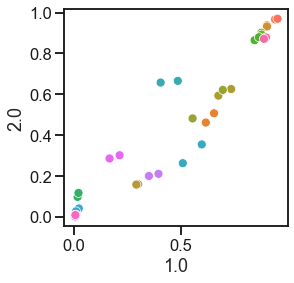

In [11]:
pivdf = gdf.pivot(index = ['plasmid', 'description', 'replicate'],
         columns = 'day',
         values = 'Citrine On').reset_index()

fig, ax = plt.subplots(figsize=(4,4))

g = sns.scatterplot(
    data = pivdf,
    x = 1.0,
    y = 2.0,
    hue = 'description',
    legend = False,
    ax=ax
)

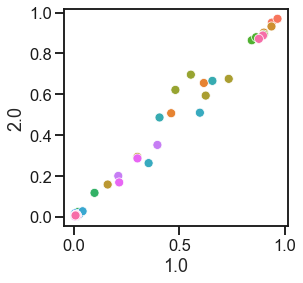

In [12]:
pivdf = gdf.pivot(index = ['plasmid', 'description', 'day'],
         columns = 'replicate',
         values = 'Citrine On').reset_index()

fig, ax = plt.subplots(figsize=(4,4))

g = sns.scatterplot(
    data = pivdf,
    x = 1.0,
    y = 2.0,
    hue = 'description',
    legend = False,
    ax=ax
)

# The summary so far

Things mostly validate. We want to now make the nice histogram plots for the validations, as well as the correlation between screen score and histogram. 

# Histogram validations

In [13]:
df

,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry,Citrine On
0,357657344.0,130077184.0,0.0,rTetR only,214476800.0,935936.0,1260,1.0,True,True,False
1,613253888.0,186921472.0,0.0,rTetR only,88771328.0,1988608.0,1260,1.0,True,True,False
2,409882368.0,184542208.0,0.0,rTetR only,340477184.0,2286848.0,1260,1.0,True,True,False
3,438074880.0,229615616.0,0.0,rTetR only,140216320.0,2050560.0,1260,1.0,True,True,False
4,550200064.0,295275008.0,0.0,rTetR only,163602944.0,2893824.0,1260,1.0,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1685738,518283520.0,158495488.0,2.0,NOTC2 - Ctrl,98124544.0,1948672.0,157,2.0,True,True,False
1685739,722553088.0,150331904.0,2.0,NOTC2 - Ctrl,40823296.0,2093056.0,157,2.0,True,True,False
1685740,759366144.0,261527296.0,2.0,NOTC2 - Ctrl,191577600.0,2949632.0,157,2.0,True,True,False
1685741,552823296.0,149416960.0,2.0,NOTC2 - Ctrl,106409984.0,2251008.0,157,2.0,True,True,False


CPU times: user 1min 36s, sys: 5.05 s, total: 1min 41s
Wall time: 14.5 s


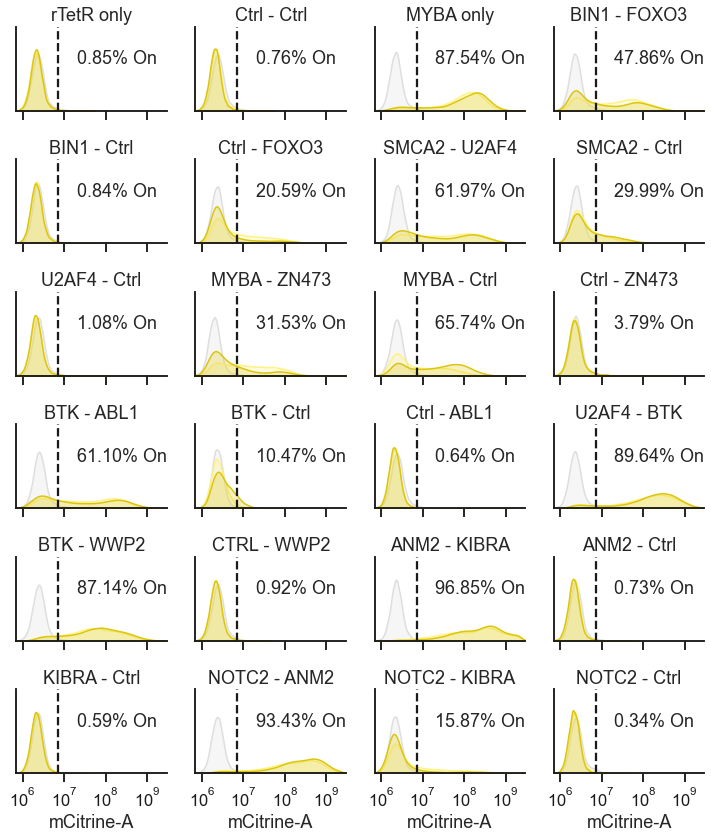

In [14]:
%%time

g = sns.FacetGrid(
    data = df,
    col = 'description',
    col_wrap = 4,
    hue = 'day',
    palette = ['#DEDEDE', '#fff280', '#DBC60D'],
    height = 2,
    aspect = 1.3
)

g.map_dataframe(
    sns.kdeplot,
    'mCitrine-A',
    log_scale = True,
    common_norm = False,
    fill = True
)

for ax in g.axes:
    ax.set_xlim([7e5, 3e9])
    ax.set_xticks([1e6, 1e7, 1e8, 1e9])
    ax.set_ylim([0, 4])
    ax.set_yticks([])
    
    relevant_plasmid = plasmids[list(g.axes).index(ax)]
    ax.set_title(plasmid_dict[relevant_plasmid])
    
    ax.axvline(get_citrine_threshold(2), color='k', linestyle='--')
    
    pdf = df[(df['plasmid']==relevant_plasmid)&(df['day']==2)]
    if pdf.shape[0] == 0:
        print(relevant_plasmid, plasmid_dict[relevant_plasmid])
    f_on = np.nanmean(list(pdf['Citrine On']))
    
    ax.text(2e7, 2.25, "{:.2f}".format(f_on*100)+"% On")
    
g.savefig('./activation_omnibus.pdf', bbox_inches = 'tight')
g.savefig('./activation_omnibus.png', dpi = 300)

In [15]:
tqdm.tqdm_notebook()

<ipython-input-15-27297fd6e26f>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [16]:
pds = sorted(list(set(df['plasmid'])))
for p in tqdm.notebook.tqdm(pds):
#     print(p)
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.kdeplot(
        data = df[df['plasmid']==p],
        x = 'mCitrine-A',
        hue = 'day',
    palette = ['#DEDEDE', '#fff280', '#DBC60D'],

        log_scale = True,
        common_norm = False,
        fill = True,
        ax = ax
    )
    
    ax.set_xlim([7e5, 3e9])
    ax.set_xticks([1e6, 1e7, 1e8, 1e9])
    ax.set_ylim([0, 4])
    ax.set_yticks([])
    
    ax.set_title(plasmid_dict[p])    
    ax.axvline(get_citrine_threshold(2), color='k', linestyle='--')
    
    pdf = df[(df['plasmid']==p)&(df['day']==2)]
    f_on = np.mean(list(pdf['Citrine On']))
    
    ax.text(1e7, 2.5, "{:.2f}".format(f_on*100)+"% On")
    fig.savefig('./histograms/' + str(plasmid_dict[p]) + ' Activation Hist.pdf', bbox_inches = 'tight')
    plt.close(fig)
    
plt.close('all')

  0%|          | 0/24 [00:00<?, ?it/s]

# Correlation with screen

In [17]:
screen_data = pd.read_csv('../../Analysis/20211021b_synergy_with_medians/pairs_baseline_sums_computed.csv')
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,act_hit,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,True,False,0.073816,0.216122,-7.111908,NaN,NaN,NaN,1.319031,2.481098
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,5.250421,0.771599
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,-3.524457,-1.582110
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,True,True,0.178962,-0.339994,-8.623200,0.178962,-0.339994,-8.623200,4.963128,1.678479
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,False,NaN,5.129901,1.486742,4.050937,NaN,NaN,NaN,-3.418116,-0.057886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.386730,-0.391739,1.123830,NaN,NaN,NaN,-3.335826,-2.120403
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.446548,-0.480109,0.872274,6.952695,6.040754,6.560139,-3.690516,-1.654426
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.386730,-0.391739,1.123830,6.952695,6.040754,6.560139,-3.949888,-2.584959
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.446548,-0.480109,0.872274,-1.278913,-0.444267,-5.456627,-2.308094,3.120483


In [18]:
df

,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry,Citrine On
0,357657344.0,130077184.0,0.0,rTetR only,214476800.0,935936.0,1260,1.0,True,True,False
1,613253888.0,186921472.0,0.0,rTetR only,88771328.0,1988608.0,1260,1.0,True,True,False
2,409882368.0,184542208.0,0.0,rTetR only,340477184.0,2286848.0,1260,1.0,True,True,False
3,438074880.0,229615616.0,0.0,rTetR only,140216320.0,2050560.0,1260,1.0,True,True,False
4,550200064.0,295275008.0,0.0,rTetR only,163602944.0,2893824.0,1260,1.0,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1685738,518283520.0,158495488.0,2.0,NOTC2 - Ctrl,98124544.0,1948672.0,157,2.0,True,True,False
1685739,722553088.0,150331904.0,2.0,NOTC2 - Ctrl,40823296.0,2093056.0,157,2.0,True,True,False
1685740,759366144.0,261527296.0,2.0,NOTC2 - Ctrl,191577600.0,2949632.0,157,2.0,True,True,False
1685741,552823296.0,149416960.0,2.0,NOTC2 - Ctrl,106409984.0,2251008.0,157,2.0,True,True,False


In [19]:
qdf = df[(df['day']==2)]
qdf = qdf.groupby(['plasmid', 'description']).mean().reset_index()
qdf = qdf[qdf['plasmid'] < 1000] 

descrs = list(qdf['description'])
splits = [d.split(' - ') for d in descrs]
d1s = [s[0] if s[0] != 'Ctrl' else 'DMD_control_tiles;ENSG00000198947;;297;' for s in splits]
d2s = [s[1] if s[1] != 'Ctrl' else 'DMD_control_tiles;ENSG00000198947;;297;' for s in splits]

qdf['domain1'] = d1s
qdf['domain2'] = d2s

qdf['frankendescr'] = [d1 + ' --- ' + d2 for d1, d2 in zip(d1s, d2s)]

qdf

,plasmid,description,FSC 488/10-A,SSC 488/10-A,day,mCherry-A,mCitrine-A,replicate,P1,mCherry,Citrine On,domain1,domain2,frankendescr
0,78,Ctrl - Ctrl,6.935798e+08,2.015884e+08,2.0,1.686651e+08,2.275942e+06,1.321569,1.0,1.0,0.007634,DMD_control_tiles;ENSG00000198947;;297;,DMD_control_tiles;ENSG00000198947;;297;,DMD_control_tiles;ENSG00000198947;;297; --- DM...
1,79,ANM2 - KIBRA,6.851799e+08,2.079998e+08,2.0,2.095951e+08,4.312927e+08,1.668377,1.0,1.0,0.968464,ANM2,KIBRA,ANM2 --- KIBRA
2,80,BIN1 - FOXO3,6.459822e+08,1.896686e+08,2.0,1.316208e+08,4.082577e+07,1.379701,1.0,1.0,0.478623,BIN1,FOXO3,BIN1 --- FOXO3
3,90,NOTC2 - ANM2,6.645409e+08,2.004126e+08,2.0,1.899924e+08,3.851975e+08,1.566755,1.0,1.0,0.934332,NOTC2,ANM2,NOTC2 --- ANM2
4,91,NOTC2 - KIBRA,6.430370e+08,1.876871e+08,2.0,1.775196e+08,2.096878e+07,1.503989,1.0,1.0,0.158689,NOTC2,KIBRA,NOTC2 --- KIBRA
5,92,SMCA2 - U2AF4,7.375351e+08,2.094567e+08,2.0,2.593349e+08,9.793103e+07,1.177432,1.0,1.0,0.619666,SMCA2,U2AF4,SMCA2 --- U2AF4
6,125,BTK - ABL1,6.854448e+08,2.030222e+08,2.0,1.536709e+08,1.029058e+08,1.928017,1.0,1.0,0.611003,BTK,ABL1,BTK --- ABL1
7,126,U2AF4 - BTK,6.488567e+08,1.906855e+08,2.0,1.654930e+08,3.023271e+08,1.508970,1.0,1.0,0.896449,U2AF4,BTK,U2AF4 --- BTK
8,127,BTK - WWP2,6.962071e+08,2.080024e+08,2.0,2.005532e+08,1.449032e+08,1.466670,1.0,1.0,0.871364,BTK,WWP2,BTK --- WWP2
9,129,BTK - Ctrl,6.876555e+08,2.063866e+08,2.0,2.675389e+08,4.028980e+06,1.377903,1.0,1.0,0.104663,BTK,DMD_control_tiles;ENSG00000198947;;297;,BTK --- DMD_control_tiles;ENSG00000198947;;297;


In [20]:
# filter for screen data with the control

sd = screen_data[(screen_data['type']=='0 control Pair')|(screen_data['pair'].str.contains('DMD_control_tiles;ENSG00000198947;;297;'))]

d1s = sd['domain1']
d2s = sd['domain2']
g1s = sd['d1_Gene']
g2s = sd['d2_Gene']

e1s = [d if 'control' in d else g for d, g in zip(d1s, g1s)]
e2s = [d if 'control' in d else g for d, g in zip(d2s, g2s)]

sd['frankendescr'] = [e1 + ' --- ' + e2 for e1, e2 in zip(e1s, e2s)]

sd

<ipython-input-20-a498b3beaa85>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5,frankendescr
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,False,0.073816,0.216122,-7.111908,NaN,NaN,NaN,1.319031,2.481098,NCOA2 --- TET2
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5.250421,0.771599,SERTAD2 --- SERTAD2
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,True,NaN,NaN,NaN,NaN,NaN,NaN,-3.524457,-1.582110,HES2 --- HES2
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,True,0.178962,-0.339994,-8.623200,0.178962,-0.339994,-8.623200,4.963128,1.678479,ZN473 --- ZN473
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,NaN,5.129901,1.486742,4.050937,NaN,NaN,NaN,-3.418116,-0.057886,HERC2 --- ADRM1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8320,Short_nuclear_domain;HXA13_HUMAN;Homeodomain;3...,0 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.056264,2.096968,-0.043040,NaN,NaN,NaN,-4.395608,-2.572494,HXA13 --- ZNF10
8321,Short_nuclear_domain;CRTC2_HUMAN;TORC_C;613;77...,0 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.035340,-0.785326,-5.293256,-0.921192,-1.436593,-5.955518,0.176384,4.248111,CRTC2 --- ZN597
8322,Short_nuclear_domain;CXXC1_HUMAN;PHD;12;48 ---...,0 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.278913,-0.444267,-5.456627,2.797788,3.347701,4.508193,-3.240455,0.808526,CXXC1 --- JDP2
8323,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50 -...,0 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.513346,4.151363,5.335222,4.869726,1.409002,2.666019,-4.864372,-3.472908,MPP8 --- ID2


In [21]:
mdf = qdf.set_index('frankendescr').join(
    sd.set_index('frankendescr'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
# mdf = mdf[mdf['character'] != 'Control']
# mdf = mdf[mdf['description'] != 'DMD - DMD']
# mdf = mdf[mdf['description'] != 'DMD - RANDCTRL']
mdf

,frankendescr,plasmid,description,FSC 488/10-A,SSC 488/10-A,day,mCherry-A,mCitrine-A,replicate,P1,...,act_hit,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5
0,DMD_control_tiles;ENSG00000198947;;297; --- DM...,78,Ctrl - Ctrl,6.935798e+08,2.015884e+08,2.0,1.686651e+08,2.275942e+06,1.321569,1.0,...,False,False,-0.481389,-0.300723,0.880544,-0.481389,-0.300723,0.880544,-2.371911,3.017499
1,ANM2 --- KIBRA,79,ANM2 - KIBRA,6.851799e+08,2.079998e+08,2.0,2.095951e+08,4.312927e+08,1.668377,1.0,...,True,False,-1.019050,-0.726941,-5.645672,0.243639,0.312334,-6.707792,-0.120025,3.256295
2,BIN1 --- FOXO3,80,BIN1 - FOXO3,6.459822e+08,1.896686e+08,2.0,1.316208e+08,4.082577e+07,1.379701,1.0,...,True,True,2.683747,1.246747,1.224325,1.492156,1.681687,-8.389172,1.378309,1.267080
3,NOTC2 --- ANM2,90,NOTC2 - ANM2,6.645409e+08,2.004126e+08,2.0,1.899924e+08,3.851975e+08,1.566755,1.0,...,True,False,0.759808,0.077752,-5.258400,-1.019050,-0.726941,-5.645672,-0.888663,3.056657
4,NOTC2 --- KIBRA,91,NOTC2 - KIBRA,6.430370e+08,1.876871e+08,2.0,1.775196e+08,2.096878e+07,1.503989,1.0,...,True,True,0.759808,0.077752,-5.258400,0.243639,0.312334,-6.707792,-0.184195,2.636461
5,SMCA2 --- U2AF4,92,SMCA2 - U2AF4,7.375351e+08,2.094567e+08,2.0,2.593349e+08,9.793103e+07,1.177432,1.0,...,True,False,1.088938,0.870292,-6.791645,-0.053175,0.131211,-3.355393,-1.703871,2.114325
6,BTK --- ABL1,125,BTK - ABL1,6.854448e+08,2.030222e+08,2.0,1.536709e+08,1.029058e+08,1.928017,1.0,...,True,False,-0.812399,-0.459171,-2.565125,-0.411887,-0.154979,-2.672821,-2.010551,4.139239
7,U2AF4 --- BTK,126,U2AF4 - BTK,6.488567e+08,1.906855e+08,2.0,1.654930e+08,3.023271e+08,1.508970,1.0,...,True,False,-0.053175,0.131211,-3.355393,-0.812399,-0.459171,-2.565125,-1.859939,3.465532
8,BTK --- WWP2,127,BTK - WWP2,6.962071e+08,2.080024e+08,2.0,2.005532e+08,1.449032e+08,1.466670,1.0,...,True,False,-0.812399,-0.459171,-2.565125,-0.697467,-0.373737,-4.048958,-2.146865,3.712469
9,BTK --- DMD_control_tiles;ENSG00000198947;;297;,129,BTK - Ctrl,6.876555e+08,2.063866e+08,2.0,2.675389e+08,4.028980e+06,1.377903,1.0,...,False,False,-0.812399,-0.459171,-2.565125,-0.481389,-0.300723,0.880544,-1.956999,3.708360


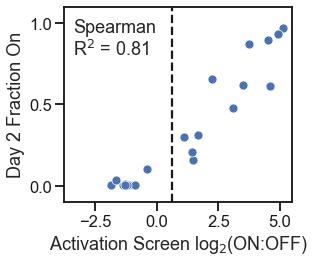

In [23]:
fig, ax = plt.subplots(figsize=(4.5,4))

sns.scatterplot(
    data = mdf.dropna(subset=['character']),
    x = 'avg_enrichment_d2',
    y = 'Citrine On',
#     hue = 'character',
#     palette = ['#dbc60d', '#23bedb', "#0fa616", "#dddddd"],
    ax=ax
)

ax.axvline(0.612, color='k', linestyle='--')

# fit line to actual data
# ldf = mdf.dropna(subset=['character'])
# ldf = mdf[mdf['avg_enrichment_d2']>0]
# m, b = np.polyfit(ldf['avg_enrichment_d2'], ldf['Citrine On'], 1)
# r, p = st.pearsonr(ldf['avg_enrichment_d2'], ldf['Citrine On'])
# ax.text(1.5, 0, "R$^2$ = {:.2f}".format(r**2))
r, p = st.spearmanr(mdf['avg_enrichment_d2'], mdf['Citrine On'], nan_policy = 'omit')
ax.text(-3.4, 0.8, "Spearman\nR$^2$ = {:.2f}".format(r**2))

ax.set_xlim(-3.75, 5.5)
ax.set_ylim(-0.1, 1.1)
ax.set_yticks([0, 0.5, 1])

# ax.legend(title='', markerscale=1.0, bbox_to_anchor = (1.05, 1),
#          labels = ['C-C', ])

ax.set_xlabel('Activation Screen log$_2$(ON:OFF)')
ax.set_ylabel('Day 2 Fraction On')

plt.tight_layout()

# fig.savefig('./activator_correlation.png', dpi = 300)
# fig.savefig('./activator_correlation.pdf', bbox_inches = 'tight')

In [24]:
mdf.to_csv('./activation_data.csv', index = False)

# Comparing Synergy

In [51]:
sdf = mdf[mdf['type'] == '1 control Pair']

sdf['domain'] = [[x for x in d.split(' - ') if x != 'Ctrl'][0] for d in sdf['description']]

sdf

baseline_dict = {
    d : s for d, s in zip(list(sdf['domain']), list(sdf['Citrine On']))
}

<ipython-input-51-01175b78b357>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
sdf[['domain', 'Citrine On']]

,domain,Citrine On
9,BTK,0.104663
10,ABL1,0.006359
11,U2AF4,0.010843
13,MYBA,0.657444
15,ZN473,0.037922
16,ANM2,0.007286
17,KIBRA,0.005860
18,BIN1,0.008419
19,FOXO3,0.205928
20,SMCA2,0.299924


In [58]:
ddf = mdf[mdf['type'] == '0 control Pair']

doms = [d.split(' - ') for d in list(ddf['description'])]
d1s = [d[0] for d in doms]
d2s = [d[1] for d in doms]

ddf['dom1_baseline'] = [baseline_dict[d] if d in baseline_dict else np.nan for d in d1s]
ddf['dom2_baseline'] = [baseline_dict[d] if d in baseline_dict else np.nan for d in d2s]
ddf['baseline_sum'] = ddf['dom1_baseline'] + ddf['dom2_baseline']

ddf[['plasmid', 'description', 'avg_enrichment_d2',
    'd1_med_d2', 'd2_med_d2', 'dom1_baseline', 'dom2_baseline', 'baseline_sum',
    'Citrine On']]

<ipython-input-58-1e31fb339ed9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-58-1e31fb339ed9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-58-1e31fb339ed9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,plasmid,description,avg_enrichment_d2,d1_med_d2,d2_med_d2,dom1_baseline,dom2_baseline,baseline_sum,Citrine On
1,79,ANM2 - KIBRA,5.136020,-0.412247,0.292221,0.007286,0.005860,0.013146,0.968464
2,80,BIN1 - FOXO3,3.090096,-1.400647,2.778955,0.008419,0.205928,0.214347,0.478623
3,90,NOTC2 - ANM2,4.922436,-0.476416,-0.412247,0.003393,0.007286,0.010679,0.934332
4,91,NOTC2 - KIBRA,1.467041,-0.476416,0.292221,0.003393,0.005860,0.009253,0.158689
5,92,SMCA2 - U2AF4,3.505392,-0.614976,-1.088896,0.299924,0.010843,0.310767,0.619666
6,125,BTK - ABL1,4.588102,-0.771043,-1.239508,0.104663,0.006359,0.111022,0.611003
7,126,U2AF4 - BTK,4.502125,-1.088896,-0.771043,0.010843,0.104663,0.115506,0.896449
8,127,BTK - WWP2,3.744941,-0.771043,-1.375822,0.104663,NaN,NaN,0.871364
14,134,MYBA - ZN473,1.688980,3.280477,2.481564,0.657444,0.037922,0.695365,0.315294


<AxesSubplot:xlabel='baseline_sum', ylabel='avg_enrichment_d2'>

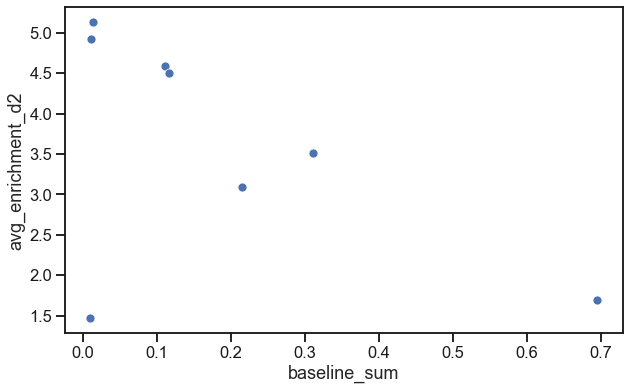

In [54]:
sns.scatterplot(
    data = ddf,
    y = 'avg_enrichment_d2',
    x = 'baseline_sum'
)